In [1]:
import cv2
import numpy as np
import sys
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import math

sys.path.append("../dataset_filtering")
from data_generation import DataGeneration
from filter_cats import filtered_cats

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


In [3]:
SIZE_X = 224
SIZE_Y = 224
WANTED_CATS = ['tomato-sauce', 'avocado']
N_CATS = len(WANTED_CATS)

INPUT_SHAPE = (SIZE_X, SIZE_Y, 3)
BATCH_SIZE = 16

TRAIN_IMAGES_PATH = "../data/train/images"
TRAIN_ANNOTATIONS_PATH = "../data/train/annotations.json"
TEST_IMAGES_PATH = "../data/test/images"
TEST_ANNOTATIONS_PATH = "../data/test/annotations.json"

In [4]:
def batch_train_generator(batchsize, images_path, annotation_path):
  print("Train generator created")
  i_img = 0
  coco = COCO(annotation_path)

  categories_ids, categories_names, img_ids = filtered_cats(coco, cat_names=WANTED_CATS)

  images = coco.loadImgs(img_ids)
  img_paths = [img["file_name"] for img in images]

  data_gen = DataGeneration(coco, SIZE_X, SIZE_Y, categories_ids)

  while True:
    inputs = np.zeros((batchsize, SIZE_X, SIZE_Y, 3))
    outputs = np.zeros((batchsize, SIZE_X, SIZE_Y, N_CATS))

    for i in range(batchsize):
      inputs[i] = data_gen.x_sample(join(images_path, img_paths[i_img]))
      outputs[i] = data_gen.y_sample(img_ids[i_img])
      i_img = (i_img + 1) % len(img_paths)

    yield normalize(inputs), outputs

In [5]:
def batch_val_generator(batchsize, images_path, annotation_path):
  print("Val generator created")
  i_img = 0
  coco = COCO(annotation_path)

  categories_ids, categories_names, img_ids = filtered_cats(coco, cat_names=WANTED_CATS)

  images = coco.loadImgs(img_ids)
  img_paths = [img["file_name"] for img in images]

  data_gen = DataGeneration(coco, SIZE_X, SIZE_Y, categories_ids)

  while True:
    inputs = np.zeros((batchsize, SIZE_X, SIZE_Y, 3))
    outputs = np.zeros((batchsize, SIZE_X, SIZE_Y, N_CATS))

    for i in range(batchsize):
      print(img_paths[i_img])
      inputs[i] = data_gen.x_sample(join(images_path, img_paths[i_img]))
      outputs[i] = data_gen.y_sample(img_ids[i_img])
      i_img = (i_img + 1) % len(img_paths)

    yield normalize(inputs), outputs

In [6]:
def get_steps_per_epoch(batchsize, annotation_path):
  coco = COCO(annotation_path)
  categories_ids, categories_names, img_ids = filtered_cats(coco, cat_names=WANTED_CATS)

  return int(math.floor(len(img_ids) / batchsize) - 1)

In [7]:
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.1)(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

In [8]:
def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

In [9]:
def build_vgg19_unet(input_shape, n_classes=1):
  """ Input """
  inputs = Input(input_shape)

  """ Pre-trained VGG19 Model """
  vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
  for layer in vgg19.layers:
    layer.trainable = False

  """ Encoder """
  s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
  s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
  s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
  s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

  """ Bridge """
  b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)

  """ Decoder """
  d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
  d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
  d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
  d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

  """ Output """
  outputs = Conv2D(n_classes, (1,1), padding="same", activation="sigmoid")(d4)

  model = Model(inputs, outputs, name="VGG19_U-Net")
  return model

In [10]:
# model = build_vgg19_unet(INPUT_SHAPE, N_CATS)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(N_CATS)])
# model.summary()

In [11]:
callbacks = [
             ModelCheckpoint("weigths/food_segmentation_2_cats_416.h5", verbose=1, save_best_only=True),
             EarlyStopping(patience=3, monitor="val_loss"),
             TensorBoard(log_dir="/content/logs/tensorboard_logs")
]

gen_train = batch_train_generator(BATCH_SIZE, TRAIN_IMAGES_PATH, TRAIN_ANNOTATIONS_PATH)
gen_val = batch_val_generator(BATCH_SIZE, TEST_IMAGES_PATH, TEST_ANNOTATIONS_PATH)

In [12]:
# history = model.fit(
#                     gen_train,
#                     verbose=1,
#                     steps_per_epoch=get_steps_per_epoch(BATCH_SIZE, TRAIN_ANNOTATIONS_PATH),
#                     epochs=10,
#                     validation_data=gen_val,
#                     validation_steps=get_steps_per_epoch(BATCH_SIZE, TEST_ANNOTATIONS_PATH),
#                     #class_weight=class_weights,
#                     shuffle=True,
#                     callbacks=callbacks)

In [13]:
# This is done automatically by TensorFlow's callback
# model.save('food_recognition_10_epochs_test.hdf5') #Saving a model with 10 epochs

In [14]:
#Load Model
loaded_model = build_vgg19_unet(INPUT_SHAPE, N_CATS)
loaded_model.load_weights("weights/food_segmentation_2_cats.h5")


In [15]:
# Create DataGeneration instance to obtain 
coco = COCO(TEST_ANNOTATIONS_PATH)

categories_ids, categories_names, img_ids = filtered_cats(coco, cat_names=WANTED_CATS)

images = coco.loadImgs(img_ids)
img_paths = [img["file_name"] for img in images]

data_gen = DataGeneration(coco, SIZE_X, SIZE_Y, categories_ids)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


33


(-0.5, 223.5, 223.5, -0.5)

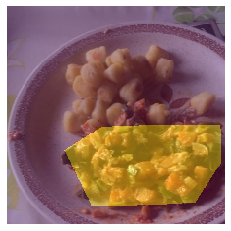

In [16]:
# Plot input data and ground truth
i_img = 5
x_test = data_gen.x_sample(join(TEST_IMAGES_PATH, img_paths[i_img]))
y_ground_truth = data_gen.y_sample(img_ids[i_img])

plt.figure()
plt.imshow(cv2.cvtColor(x_test, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.imshow(y_ground_truth[:,:,0].astype(int), alpha=0.4); plt.axis('off')

# I = cv2.imread(join(TEST_IMAGES_PATH, img_paths[i_img]))
# plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB)); plt.axis('off')
# Render annotations on top of the image
# annotation_ids = coco.getAnnIds(imgIds=img_ids[i_img], catIds=categories_ids)
# annotations = coco.loadAnns(annotation_ids)
# coco.showAnns(annotations)

In [17]:
print(np.amax(y_ground_truth.flatten()))

1.0


In [18]:
# Predict
x_input = x_test.reshape(1, SIZE_X, SIZE_Y, 3)
y_pred = model.predict(x_input)
y_pred = y_pred.reshape(SIZE_X, SIZE_Y, N_CATS)
y_pred_argmax = np.argmax(y_pred, axis=2)
print(y_pred_argmax)

NameError: name 'model' is not defined

In [ ]:
print(x_test[0,0,0])